### Lab 3 Task 2
#### Датасет: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

Пристрій: cuda
Кількість класів: 36
Початок навчання моделі: CNN
[01] train_loss=3.2179 | val_loss=2.3729 | val_acc=27.92%
[02] train_loss=2.5887 | val_loss=1.8711 | val_acc=45.01%
[03] train_loss=2.3034 | val_loss=1.5420 | val_acc=56.13%
[04] train_loss=2.0712 | val_loss=1.2836 | val_acc=64.67%
[05] train_loss=1.8499 | val_loss=1.0109 | val_acc=71.79%
Час на навчання 377.50 с
Точність на тестовій вибірці (CNN): 71.87%
Початок навчання моделі: MobileNetV2
[01] train_loss=2.4061 | val_loss=1.1140 | val_acc=81.48%
[02] train_loss=1.3064 | val_loss=0.6859 | val_acc=88.89%
[03] train_loss=0.9700 | val_loss=0.4930 | val_acc=91.74%
[04] train_loss=0.8344 | val_loss=0.4200 | val_acc=92.59%
[05] train_loss=0.7141 | val_loss=0.3589 | val_acc=93.16%
Час на навчання 366.19 с
Точність на тестовій вибірці (MobileNetV2): 93.31%


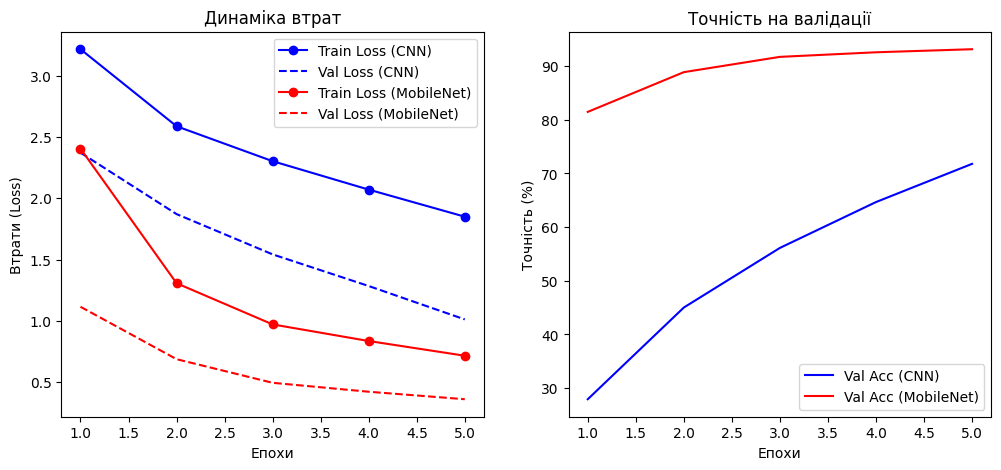

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import time

torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Пристрій:", device)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Завантаження наборів даних
train_dataset = datasets.ImageFolder("../data/train", transform=transform)
val_dataset = datasets.ImageFolder("../data/validation", transform=transform)
test_dataset = datasets.ImageFolder("../data/test", transform=transform)

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)
print(f"Кількість класів: {num_classes}")

# а) Проста згорткова нейронна мережа
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# б) MobileNetV2
def get_mobilenet_model(num_classes):
    # Завантаження попередньо натренованої моделі
    model = models.mobilenet_v2(weights='DEFAULT')
    
    for param in model.features.parameters():
        param.requires_grad = False
    
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

def train_model(model, name):
    print(f"Початок навчання моделі: {name}")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    
    best_val_loss = float('inf')
    best_model_path = f"best_model_{name}.pth"
    n_epochs = 5
    
    start_time = time.time()

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()
                
                preds = out.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        
        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.2f}%")

        # Збереження найкращої моделі
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    total_time = time.time() - start_time
    print(f"Час на навчання {total_time:.2f} с")
    
    # Завантаження найкращої моделі для тестування
    model.load_state_dict(torch.load(best_model_path))
    return train_loss_history, val_loss_history, val_acc_history, total_time

# Тестування моделі
def test_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

# Запуск навчання для CNN
cnn_model = CNN(num_classes)
loss_train_a, loss_val_a, acc_val_a, time_a = train_model(cnn_model, "CNN")
test_acc_a = test_model(cnn_model)
print(f"Точність на тестовій вибірці (CNN): {test_acc_a:.2f}%")

# Запуск навчання для MobileNetV2
mobilenet_model = get_mobilenet_model(num_classes)
loss_train_b, loss_val_b, acc_val_b, time_b = train_model(mobilenet_model, "MobileNetV2")
test_acc_b = test_model(mobilenet_model)
print(f"Точність на тестовій вибірці (MobileNetV2): {test_acc_b:.2f}%")

# Візуалізація результатів
epochs_range = range(1, 6)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_train_a, "bo-", label="Train Loss (CNN)")
plt.plot(epochs_range, loss_val_a, "b--", label="Val Loss (CNN)")
plt.plot(epochs_range, loss_train_b, "ro-", label="Train Loss (MobileNet)")
plt.plot(epochs_range, loss_val_b, "r--", label="Val Loss (MobileNet)")
plt.title("Динаміка втрат")
plt.xlabel("Епохи")
plt.ylabel("Втрати (Loss)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc_val_a, "b-", label="Val Acc (CNN)")
plt.plot(epochs_range, acc_val_b, "r-", label="Val Acc (MobileNet)")
plt.title("Точність на валідації")
plt.xlabel("Епохи")
plt.ylabel("Точність (%)")
plt.legend()

plt.show()

Результати порівняння демонструють що попередньо натренована модель MobileNetV2 значно точніша за CNN показавши точність 93.31% проти 71.87% відповідно, завдяки своїй здатності розпізнавати складні ознаки. Швидкість збіжності MobileNetV2 також виявилася набагато вищою адже вже на першій епосі вона досягла 81% точності та стабілізувала функцію втрат тоді як проста CNN почала з 27% і продовжувала навчатися навіть на п'ятій епосі.